In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy.stats import dirichlet, poisson, norm, beta
from numpy.random import choice
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

## Dirichlet Distribution

The Dirichlet distribution (DD) can be considered a distribution of distributions. Each sample from the DD is a categorial distribution over $K$ categories. It is parameterized $G_0$, a distribution over $K$ categories and $\alpha$, a scale factor.

The expected value of the DD is $G_0$. The variance of the DD is a function of the scale factor. When $\alpha$ is large, samples from $DD(\alpha\cdot G_0)$ will be very close to $G_0$. When $\alpha$ is small, samples will vary more widely. We can demonstrate by setting $G_0=[.2, .2, .6]$ and varying $\alpha$.

In [4]:
np.set_printoptions(precision=2)

def stats(scale_factor, G0=[.2, .2, .6], N=10000):
    samples = dirichlet(alpha = scale_factor * np.array(G0)).rvs(N)
    print "scale factor", scale_factor
    print "sample:", samples[0]
    print "  mean:", samples.mean(axis=0)
    print "   std:", samples.std(axis=0)
    print
    
_=[stats(scale) for scale in [0.1, 1, 10, 100, 1000]]

scale factor 0.1
sample: [  6.30e-23   4.88e-37   1.00e+00]
  mean: [ 0.2  0.2  0.6]
   std: [ 0.38  0.38  0.47]

scale factor 1
sample: [ 0.05  0.01  0.94]
  mean: [ 0.2  0.2  0.6]
   std: [ 0.28  0.28  0.35]

scale factor 10
sample: [ 0.11  0.13  0.75]
  mean: [ 0.2  0.2  0.6]
   std: [ 0.12  0.12  0.15]

scale factor 100
sample: [ 0.18  0.2   0.62]
  mean: [ 0.2  0.2  0.6]
   std: [ 0.04  0.04  0.05]

scale factor 1000
sample: [ 0.21  0.19  0.6 ]
  mean: [ 0.2  0.2  0.6]
   std: [ 0.01  0.01  0.02]



## Dirichlet Process

Heinrich:

> Informally speaking, the DP extends the DD by generalising the base distribution from the discrete $G_0$ to “almost any” distribution $H_0$ defined on some support set $S (H_0)$.

Mathematically, we can construct a sample $H$ (recall that $H$ is a probability distribution) from a Dirichlet process $\text{DP}(\alpha H_0)$ by drawing a countably infinite number of samples $\theta_k$ from $H_0$) and setting:

$$H=\sum_{k=1}^\infty \pi_k \cdot\delta(x-\theta_k)$$

where the $\pi_k$ are carefully chosen weights (more later) that sum to 1.

Thus samples from the Dirichlet process are _discrete_ distributions (even if $H_0$ is continuous) over a countably infinite subset of $S(H_0)$. Again, as $\alpha\rightarrow\infty$, the samples vary less from the base distribution. $H$, above, is a probability mass function for a discrete distribution. 

So how are the weights $\pi_k$ chosen? Heinrich, again:

> The defining property of the DP is that its samples have weights $\pi_k$ and locations $\theta_k$ distributed in such a way that when partitioning S(H) into finitely many arbitrary disjoint subsets $S_1, \ldots, S_j$ $J<\infty$, the sums of the weights $\pi_k$ in each of these $J$ subsets are distributed according to a Dirichlet distribution that is parameterized by $\alpha$ and a discrete base distribution (like $G_0$) whose weights are equal to the integrals of the base distribution $H_0$ over the subsets $S_n$.

As an example, Heinrich notes that given $H_0\sim \mathcal{N}(0,1)$ and $S_1=(-\infty, -1]$, $S_2=(-1, 1]$, and  and $S_3=(1, \infty]$ then

$$H(S_1),H(S_2), H(S_3) \sim \text{Dir}\left(\alpha\,\text{erf}(-1), \alpha\,(\text{erf}(1) - \text{erf}(-1)), \alpha\,(1-\text{erf}(1))\right)$$

where $H(S_n)$ be the sum of the $\pi_k$ values whose $\theta_k$ lie in $S_n$. These $S_n$ subsets are chosen for convenience, however similar results would hold for _any_ choice of $S_n$. 

There are several equivalent ways to choose the $\pi_k$ so that this property is satisfied: the Chinese restaurant process, the stick-breaking process, and the Pólya urn scheme. 

To generate $\left\{\pi_k\right\}$ according to a stick-breaking process we defined $\beta_k$ to be a sample from $\text{Beta}(1,\alpha)$. $\pi_1$ is defined simple $\beta_1$. Successive values are defined recursively by

$$\pi_k=\beta_k \prod_{j=1}^{k-1}(1-\beta_j).$$

Supposed we want to sample from a Dirichlet process. In theory, we could sample an infinite number of $\theta_k$ values and generated a corresponding number of $\pi_k$ weights. Sampling an infinite number of values is easier in theory than in practice.

However, by noting that the $\pi_k$ values are _positive_ values summing to 1, we note that, in expectation, they must get increasingly small as $k\rightarrow\infty$. Thus, we can reasonably approximate a sample $H\sim DP(\alpha H_0)$ by drawing a $K$ of samples such that $\sum_{k=1}^K \pi_k\approx 1$.

Below we draw (approximate) samples from several Dirichlet distribution with a standard normal ($\mathcal{N}(0,1)$) base distribution but varying $\alpha$ values. The blue line is the PDF for a standard normal. The black lines represent the $\theta_k$ and $\pi_k$ values; $\theta_k$ is indicated by the position of the black line on the $x$-axis; $\pi_k$ is proportional to the height of each line. Enough $\pi_k$ values are generated so their sum is greater than 0.99. When $\alpha$ is small, very few $\theta_k$'s will have corresponding $\pi_k$ values larger than $0.01$. However, as $\alpha$ grows large, the sample becomes a more accurate (though still discrete) approximation of $\mathcal{N}(0,1)$.

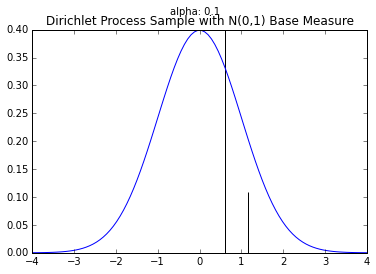

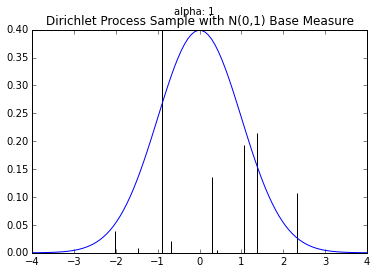

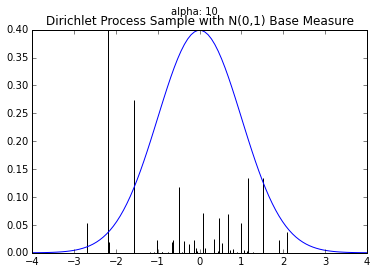

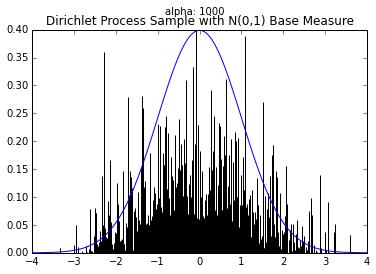

In [5]:
def dirichlet_sample_approximation(base_measure, alpha, tol=0.01):
    betas = []
    pis = []
    betas.append(beta(1, alpha).rvs())
    pis.append(betas[0])
    while sum(pis) < (1.-tol):
        s = np.sum([np.log(1 - b) for b in betas])
        new_beta = beta(1, alpha).rvs() 
        betas.append(new_beta)
        pis.append(new_beta * np.exp(s))
    pis = np.array(pis)
    thetas = np.array([base_measure() for _ in pis])
    return pis, thetas

def plot_normal_dp_approximation(alpha):
    plt.figure()
    plt.title("Dirichlet Process Sample with N(0,1) Base Measure")
    plt.suptitle("alpha: %s" % alpha)
    pis, thetas = dirichlet_sample_approximation(lambda: norm().rvs(), alpha)
    pis = pis * (norm.pdf(0) / pis.max())
    plt.vlines(thetas, 0, pis, )
    X = np.linspace(-4,4,100)
    plt.plot(X, norm.pdf(X))

plot_normal_dp_approximation(.1)
plot_normal_dp_approximation(1)
plot_normal_dp_approximation(10)
plot_normal_dp_approximation(1000)

Often we want to draw samples from a _distribution sampled from a Dirichlet process_ instead of from the Dirichlet process itself. Much of the literature on the topic unhelpful refers to this as sampling from a Dirichlet process. 

Fortunately, we don't have to draw an infinite number of samples from the base distribution and stick breaking process to do this. Instead, we can draw these samples _as they are needed_. 

Suppose, for example, we know a finite number of the $\theta_k$ and $\pi_k$ values for a sample $H\sim \text{Dir}(\alpha H_0)$. For example, we know

$$\pi_1=0.5,\; \pi_3=0.3,\; \theta_1=0.1,\; \theta_2=-0.5.$$

To sample from $H$, we can generate a uniform random $u$ number between 0 and 1. If $u$ is less than 0.5, our sample is $0.1$. If $0.5<=u<0.8$, our sample is $-0.5$. If $u>=0.8$, our sample (from $H$ will be a new sample $\theta_3$ from $H_0$. At the same time, we should also sample and store $\pi_3$. When we draw our next sample, we will again draw $u\sim\text{Uniform}(0,1)$ but will compare against $\pi_1, \pi_2$, AND $\pi_3$.

The class below will take a base distribution $H_0$ and $\alpha$ as arguments to its constructor. The class instance can then be called to generate samples from $H\sim \text{DP}(\alpha H_0)$.

In [6]:
class DirichletProcessSample():
    def __init__(self, base_measure, alpha):
        self.base_measure = base_measure
        self.alpha = alpha
        
        self.cache = []
        self.weights = []
        self.total_stick_used = 0.

    def __call__(self):
        remaining = 1.0 - self.total_stick_used
        i = DirichletProcessSample.roll_die(self.weights + [remaining])
        if i is not None and i < len(self.weights) :
            return self.cache[i]
        else:
            stick_piece = beta(1, self.alpha).rvs() * remaining
            self.total_stick_used += stick_piece
            self.weights.append(stick_piece)
            new_value = self.base_measure()
            self.cache.append(new_value)
            return new_value
        
    @staticmethod 
    def roll_die(weights):
        if weights:
            return choice(range(len(weights)), p=weights)
        else:
            return None

Below are histograms of 10000 samples drawn from _samples_ drawn from Dirichlet processes with standard normal base distribution and varying $\alpha$ values. 

Note that these histograms look very similar to the corresponding plots of sampled distributions above. However, these histograms are plotting _points sampled from a distribution sampled from a Dirichlet process_ while the plots above were showing _distributions smapled from the Dirichlet process_. Of course, as the number of samples from each $H$ grows large, we would expect the histogram to be a very good empirical approximation of $H$.

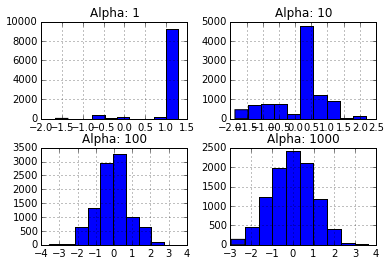

In [7]:
base_measure = lambda: norm().rvs()
n_samples = 10000
samples = {}
for alpha in [1, 10, 100, 1000]:
    dirichlet_norm = DirichletProcessSample(base_measure=base_measure, alpha=alpha)
    samples["Alpha: %s" % alpha] = [dirichlet_norm() for _ in range(n_samples)]

_ = pd.DataFrame(samples).hist()

## Vanilla LDA Generative Model Sampler

In _Parameter estimation for text analysis_, Gregor Heinrich provides pseudocode for sampling from a Latent Dirichlet Process using Dirichlet distributions:


![](http://i.imgur.com/2l0Klva.png)

Implementing this is fairly straight forward:

In [8]:
num_documents = 5
num_topics = 2
topic_dirichlet_parameter = 1 # beta
term_dirichlet_parameter = 1 # alpha
vocabulary = ["see", "spot", "run"]
num_terms = len(vocabulary) 
length_param = 10 # xi

term_distribution_by_topic = {} # Phi
topic_distribution_by_document = {} # Theta
document_length = {}
topic_index = defaultdict(list)
word_index = defaultdict(list)

term_distribution = dirichlet(num_terms * [term_dirichlet_parameter])
topic_distribution = dirichlet(num_topics * [topic_dirichlet_parameter])

# Topic plate: for each topic...
for topic in range(num_topics):
    # ...sample a multinomial distribution over the terms.
    term_distribution_by_topic[topic] = term_distribution.rvs()[0]

# Document plate: for each document...
for document in range(num_documents):
    # ...sample a multinomial distribution over the topics.
    topic_distribution_by_document[document] = topic_distribution.rvs()[0]
    topic_distribution_param = topic_distribution_by_document[document]
    # ...sample the document length from a poisson distribution.
    document_length[document] = poisson(length_param).rvs()
    
    # Word plate: for each word in the document...
    for word in range(document_length[document]):
        topics = range(num_topics)
        # ...sample the topic generating the word.
        topic = choice(topics, p=topic_distribution_param)
        topic_index[document].append(topic)
        # ...sample the term generated by the topic.
        term_distribution_param = term_distribution_by_topic[topic]
        word_index[document].append(choice(vocabulary, p=term_distribution_param))

Each word in the document was generated by a two-step process:

1. We sampled a topic from the topic distribution for the document.
2. We sampled a word from the word distribution from the topic. 

A key, but subtle, observation is that a given term (unique word) could be generated by multiple topics, i.e. there's not a 1-1 correspondance between words and topics. In the same way, there's not a 1-1 correspondance between topics and documents: a given document is a mixture of topics. 

The table below summarizes the first document by showing how many times each word is generated by each topic.

Each document $m$ corresponds to a multinomial parameter ($\overrightarrow\theta_m$) that describes the mixture of topics in the document.  

In [9]:
print "             Top 1  Top 2"
for doc, dist in topic_distribution_by_document.iteritems():
    print "Document %s: %s" % (doc, np.round(dist, 2))

             Top 1  Top 2
Document 0: [ 0.72  0.28]
Document 1: [ 0.6  0.4]
Document 2: [ 0.98  0.02]
Document 3: [ 1.  0.]
Document 4: [ 0.74  0.26]


Each term $k$ corresponds to a multinomial parameter ($\overrightarrow\phi_k$) that describes the mixture of terms in that topic.

In [10]:
print "       ", vocabulary
for doc, dist in term_distribution_by_topic.iteritems():
    print "Term %s: %s" % (doc, np.round(dist, 2))

        ['see', 'spot', 'run']
Term 0: [ 0.26  0.32  0.42]
Term 1: [ 0.26  0.18  0.55]


__When we fit the LDA model to a given text corpus, our primary objective is to find the set of topic distributions $\underline \Theta$ and term distributions $\underline \Phi$ that generated the documents.__

### Generated Documents

In [11]:
for doc in range(num_documents):
    print 'document %s:' % doc, ' '.join(word_index[doc])    

document 0: run run run run see run spot run run see run run
document 1: spot see spot see spot run see spot see see
document 2: see spot run see run run spot see spot spot run run spot run
document 3: spot spot run run run run run run run run run
document 4: see run run run run see spot spot see see spot spot run run run


### Word Distribution by Topic for Each Document

In [12]:
for document in range(num_documents):
    print "Document %s" % document
    df = pd.DataFrame([topic_index[document], word_index[document]], index=['topic', 'word']).T
    print df.groupby('topic')['word'].value_counts().unstack(level=0).fillna(0)
    print 

Document 0
topic  0  1
run    7  2
see    1  1
spot   1  0

Document 1
topic  0  1
run    0  1
see    4  1
spot   3  1

Document 2
topic  0
run    6
spot   5
see    3

Document 3
topic  0
run    9
spot   2

Document 4
topic  0  1
run    5  2
see    4  0
spot   4  0



## LDA: A Dirichlet Process Perspective

When we sample the topic index in the Latent Dirichlet Allocation topic, we are using a sample from a Dirichlet distribution ($\overrightarrow\theta_m$) as the input to our categorical distribution. In other words, we are effectively sampling from a probability distribution (defined by $\overrightarrow\theta_m$) that was sampled from a probability distribution, $\text{Dir}(\overrightarrow\alpha)$. That sounds a lot like a Dirichlet process, and indeed it is.

In our earlier algorithm, we generated a topic distribution parameter for each document from a Dirichlet _distribution_. We then used that to sample a topic from each word, and then a term for each of those topic. 

Now we will draw a _sample_ from a Dirichlet _Process_ for each document. The base distribution for the Dirichlet process is a categorical distribution over term distributions; we can think of the base distribution as an $n$-sided die where $n$ is the number of topics and each side of the die is a distribution over terms for that topic. 

For each word in the document, we will draw a _sample_ (a term distribution) from the distribution (over term distributions) _sampled_ from the Dirichlet process (with a distribution over term distributions as its base measure). Each term distribution uniquely identifies the topic for the word. We can sample from this term distribution to get the word.

In [13]:

term_distribution = dirichlet(num_terms * [term_dirichlet_parameter])
term_distributions = [term_distribution.rvs()[0] for _ in range(num_topics)]
term_distribution_rvs = lambda: term_distributions[choice(range(num_topics))]
topic_map = {topic: topic_id for topic_id, topic in enumerate(set(map(str, term_distributions)))}

topic_index = defaultdict(list)
word_index = defaultdict(list)


for doc in range(num_documents):
    topic_distribution_rvs = DirichletProcessSample(base_measure=term_distribution_rvs, 
                                                alpha=topic_dirichlet_parameter)
    document_length = poisson(length_param).rvs()
    for word in range(document_length):
        topic_distribution = topic_distribution_rvs()
        topic_index[doc].append(topic_map[str(topic_distribution)])
        word_index[doc].append(choice(vocabulary, p=topic_distribution))

Below we print the generated documents and annotate each word with the topic it was generated from. (We see again that a given word can come from multiple topics.)

In [14]:
for doc in range(num_documents):
    words = [ '-'.join(map(str, x)) for x in zip(word_index[doc], topic_index[doc])]
    print 'document %s:' % doc, ' '.join(words)    

document 0: spot-1 spot-1 see-1 spot-1 see-1 run-1 run-1 spot-1 see-1 spot-1 spot-1 spot-1
document 1: see-0 see-0 run-0 see-0 spot-1 see-0 see-0 see-0 see-0 run-0 see-0 run-0
document 2: run-0 spot-1 spot-1 spot-1 see-0 see-1 spot-1
document 3: see-1 see-1 spot-1 spot-1 spot-1 run-1 spot-1 spot-1 see-1 see-1 spot-1
document 4: see-0 see-0 see-1 see-0 see-0 spot-1 see-1 see-0 spot-0 spot-1 see-1 spot-0 see-0


## HDP-LDA Generative Model Sampler

Given this last formulation, we might ask if we can roll an _infinite_ sided die to draw from an unbounded number of topics (term distributions). We can do exactly this with a _Hierarchical_ Dirichlet process. Instead of the base distribution of our Dirichlet process being a _finite_ distribution over topics (term distributions) we will instead make it an infinite Distribution over topics (term distributions) by using yet another Dirichlet process! This base Dirichlet process will have as its base distribution a Dirichlet _distribution_ over terms. 

We will again draw a _sample_ from a Dirichlet _Process_ for each document. The base distribution for the Dirichlet process is itself a Dirichlet process whose base distribution is a Dirichlet distribution over terms. We can think of this as a countably infinite die each side of the die is a distribution over terms for that topic. The sample we draw is a topic (distribution over terms).

For each word in the document, we will draw a _sample_ (a term distribution) from the distribution (over term distributions) _sampled_ from the Dirichlet process (with a distribution over term distributions as its base measure). Each term distribution uniquely identifies the topic for the word. We can sample from this term distribution to get the word.

In [15]:
num_documents = 5
topic_dirichlet_parameter = 3 # beta
gamma = 1 # gamma
alpha0 = 1 # alpha0

vocabulary = ["see", "spot", "run"]
num_terms = len(vocabulary) 
length_param = 10 # xi

base_distribution = lambda: dirichlet(alpha=num_terms * [gamma]).rvs()[0]
term_distribution_rvs = DirichletProcessSample(base_distribution, alpha=alpha0)

topic_map = {}

topic_index = defaultdict(list)
word_index = defaultdict(list)


for doc in range(num_documents):
    topic_distribution_rvs = DirichletProcessSample(base_measure=term_distribution_rvs, 
                                                alpha=topic_dirichlet_parameter)
    document_length = poisson(length_param).rvs()
    for word in range(document_length):
        topic_distribution = topic_distribution_rvs()
        
        if str(topic_distribution) not in topic_map:
            topic_map[str(topic_distribution)] = max(topic_map.values() or [-1]) + 1
        topic_index[doc].append(topic_map[str(topic_distribution)])
        word_index[doc].append(choice(vocabulary, p=topic_distribution))

### Generated Documents

In [16]:
for doc in range(num_documents):
    print 'document %s:' % doc, ' '.join(word_index[doc])    

document 0: run spot see spot run run see
document 1: run see run see run run see see spot spot run see see run run spot
document 2: run spot see run run see run see spot see see run
document 3: run spot see spot see spot run run spot see see
document 4: run see see spot run see run see see run see


### Term Distributions by Topic

In [17]:
print '         ', '   '.join(vocabulary)
for s, d in enumerate(term_distribution_rvs.cache):
    print 'topic %s' % s, d

          see   spot   run
topic 0 [ 0.46  0.28  0.26]
topic 1 [ 0.53  0.09  0.37]
topic 2 [ 0.34  0.07  0.6 ]
topic 3 [ 0.48  0.2   0.32]


### Word Distribution by Topic for Each Document

In [18]:
for document in range(num_documents):
    print "Document %s" % document
    df = pd.DataFrame([topic_index[document], word_index[document]], index=['topic', 'word']).T
    print df.groupby('topic')['word'].value_counts().unstack(level=0).fillna(0)
    print 

Document 0
topic  0
run    3
see    2
spot   2

Document 1
topic  0  1  2
run    1  5  1
see    2  4  0
spot   0  3  0

Document 2
topic  0  3
run    4  1
see    4  1
spot   2  0

Document 3
topic  0
see    4
spot   4
run    3

Document 4
topic  0  1
run    4  0
see    5  1
spot   1  0

